<img src="../assets/logo.png" width="50" align="left"> 

# Doppler

***

#### Prerequesites
- Sampling Data
- Range

In [1]:
# Imports
import numpy as np                  # Scientific Computing Library
import matplotlib.pyplot as plt     # Basic Visualization Library

## Intro - Back to Our Previous Example

<img src="../assets/speedometer.png" width="400">

Think back to our movie example, we went through some steps to extracting range information from our radar data. This is good for reconstructing the dramatic movie scene, but there are still a lot of things missing. One piece of key information that doesn't necessarily show up on the screen is still left to be discovered. That, of course, is speed. By using radar, we should be able to find out how fast an object is approaching, or fleeting. 

## What the Radar Sees

Last time, we used the way the ADC samples were captured to find range. We said that since they were captured equispaced apart in time, they formed a time log of sorts we could access. Conceptually, let's think about what would happen if we used that same technique for capturing chirps as well as samples. 

Some object in front of the radar will reflect portions of the first chirp. Now the second, third, and so on chirps hit this object and reflect. For simplicity, let's assume that the object is stayed within a single range bin for the duration of the entire frame and is moving at a constant velocity. There should be some set of samples across the separate chirps that hold this valuable information. Think about what each of them look like relative to the previous and next.

## Doppler Effect

The doppler effect is what happens when a wave hits a moving object. The intuition behind it is simple, if you throw a bouncy ball at something moving it will either return faster or slower than normal. For waves, what is affected is the frequency of the wave after it bounces off of the object since the peaks in the wave either spread out or get closer together. This means there is some relation between the frequency of the wave and the velocity of the object it hits (additionally the source of the wave if it isn't already stationary). The elementary equation for this is...

$f' = \frac{v+v_0}{v-v_s}f$

However, this equation works with sound waves (which do not obey the equation $c=\lambda f$ that the EM waves radar generates). We need a new method for finding this change in velocity with waves that are moving at the speed of light.

## Discovering Meaning in the Chirps

In addition to multiple ADC samples, we have multiple chirps. For an object at range $x$ from the radar, when we receive the respective ADC sample, the product will be a complex number with some phase. If the object is moving away from the radar, the respective ADC sample of the second chirp will come in at a very slightly delayed time. This is because the object also moved slightly away in that miniscule amount of time. Althought this movement is miniscule, the change in phase of the wave can be clearly seen.

# Processing Doppler Information

***

## Step 1 - Range FFT

Let's start with something that we've already done, but expand it slightly. We know from the last reading that we can do a FFT across the data samples we receive to get range information. However, the data I'm providing this time is from a whole **frame** instead of a single **chirp**. Adjust your method to account for this.

In [7]:
# Read in frame data
frame = np.load('../assets/simple_frame_1.npy')

# Manually cast to signed ints
frame.real = frame.real.astype(np.int16)
frame.imag = frame.imag.astype(np.int16)

# Meta data about the data
num_chirps = 128 # Number of chirps in the frame
num_samples = 128 # Number of ADC samples per chirp

In [8]:
#################### TODO ####################
"""
    Task: Perform the range FFt on the entire frame
    Output: range_plot [chirps, range_bins]
    
    Details: This should be very similar to last time, although the input is now of shape [chirps, adc_samples]
"""

# Range FFT

##############################################

'\n    Task: Perform the range FFt on the entire frame\n    Output: range_plot [chirps, range_bins]\n    \n    Details: This should be very similar to last time, although the input is now of shape [chirps, adc_samples]\n'

In [9]:
""" REMOVE """
range_plot = np.fft.fft(frame, axis=1)

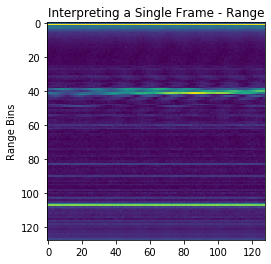

In [10]:
# Visualize Results
plt.imshow(np.abs(range_plot).T)
plt.ylabel('Range Bins')
plt.title('Interpreting a Single Frame - Range')
plt.show()

## Step 2 - Doppler FFT

Looking into the produced plot, it's starting to look like the radar definitely sees something at various ranges. Notably, we can see peak lines at range bins ~40 and ~115. Still, it's hard to tell exactly what. We should now try and also obtain velocity information.

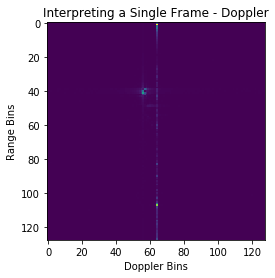

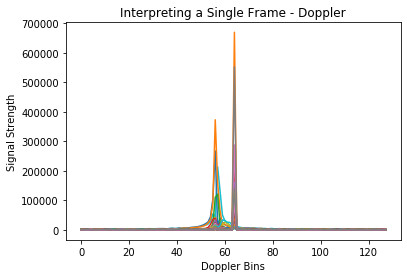

In [11]:
# Take a sequential FFT across the chirps
range_doppler = np.fft.fft(range_plot, axis=0)

# FFT shift the values (explained later)
range_doppler = np.fft.fftshift(range_doppler, axes=0)

# Visualize the range-doppler plot
# plt.imshow(np.log(np.abs(range_doppler).T))
plt.imshow(np.abs(range_doppler).T)
plt.xlabel('Doppler Bins')
plt.ylabel('Range Bins')
plt.title('Interpreting a Single Frame - Doppler')
plt.show()

plt.plot(np.abs(range_doppler))
plt.xlabel('Doppler Bins')
plt.ylabel('Signal Strength')
plt.title('Interpreting a Single Frame - Doppler')
plt.show()

Interesting, there are definitely more things that we can tell from these plots just by decoding the velocity, but we need to know how to decipher them first. This is easy, and very similar to deciphering range from range bins. Additionally, we FFT shifted across the chirps to make it more intuitive to understand. That line in the middle at doppler bin 64 is called zero doppler, meaning everything along that line is static/not moving relative to the radar. This means everything to the left (bins<64) is negative doppler, or moving towards the radar and the opposite for the other half of the doppler bins.


Some things that you may have observed:
1. Much of the received signal translates to having zero doppler, which makes sense if you think about it because most of the objects around us (and the radar) are not moving and thus zero doppler relative to us.
2. The plots show at range bin ~40, there is a grouping of peaks in intensity off to the left, meaning an object is most likely moving towards the radar.
3. Also, at range bin ~115, we see there is a peak in the middle of the doppler bins, meaning there is probably a highly reflective static object in front of the radar. These described peaks are more clearly shown in the second plot.

### Note

It's possible you noticed some things after finishing these two steps. 
1. Why did we take the range FFT/what if we don't need range?
    - You really don't need to, but many tasks do require the range information that comes out of a radar. If yours doesn't need that information then you could probably get away with not taking it.
2. Why did we have to take the range FFT before we did the doppler FFT?
    - Again, no reason. Futhermore, for this case, the properies of the 2D FFT hold and we can actually do either direction. I can prove it right here...

In [12]:
# Range FFT -> Doppler FFT
range_bins = np.fft.fft(frame, axis=1)
fft_2d = np.fft.fft(range_bins, axis=0)

# Doppler FFT -> Range FFT
doppler_bins = np.fft.fft(frame, axis=0)
rfft_2d = np.fft.fft(doppler_bins, axis=1)

print('Max power difference: ', np.abs(fft_2d - rfft_2d).max())

Max power difference:  5.64766185425834e-11


Which is pretty close to zero (not necessarily zero because of bit level rounding errors)

## Step 3 - Unit Conversion

All the units of the data we produced are of some type of "bin". Similarly to range resolution, we have a doppler resolution aka velocity resolution. This can be applied in a similar way, but first let's derive an equation. Again we start with some given equations...

- $\omega = \frac{4\pi vT_c}{\lambda}$ - Rotational frequency of phasor due to object moving at $v$ velocity
    - $v$ - Velocity
    - $T_c$ - Sampling period
    - $\lambda$ - Wavelength
- $\Delta\omega \gt \frac{2\pi}{N}$ - Minimum change in rotation of phasor to be resolved by radar
    - $N$ - Number of sample points

Now its your turn to try and derive our velocity resolution equation. 

Solve this equation: $\Delta v > ???$

In [13]:
# Data sampling configuration
c = 3e8 # Speed of light (m/s)
sample_rate = 2500 # Rate at which the radar samples from ADC (ksps - kilosamples per second)
freq_slope = 60 # Frequency slope of the chirp (MHz/us)
adc_samples = 128 # Number of samples from a single chirp

start_freq = 77.4201 # Starting frequency of the chirp (GHz)
idle_time = 30 # Time before starting next chirp (us)
ramp_end_time = 62 # Time after sending each chirp (us)
num_chirps = 128 # Number of chirps per frame
num_tx = 2 # Number of transmitters

# Range resolution
range_res = (c * sample_rate * 1e3) / (2 * freq_slope * 1e12 * adc_samples)
print(f'Range Resolution: {range_res} [meters/second]')

# Apply the range resolution factor to the range indices
ranges = np.arange(adc_samples) * range_res

Range Resolution: 0.048828125 [meters/second]


Velocity Resolution: 0.08226398402437117 [meters/second]


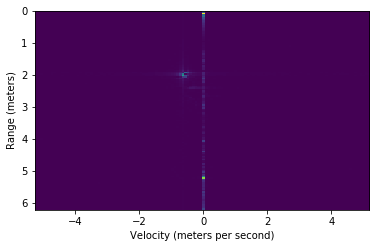

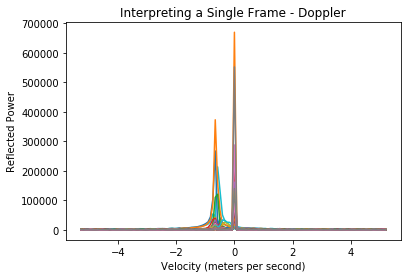

In [14]:
# Make sure your equation translates to the following
velocity_res = c / (2 * start_freq * 1e9 * (idle_time + ramp_end_time) * 1e-6 * num_chirps * num_tx)
print(f'Velocity Resolution: {velocity_res} [meters/second]')

# Apply the velocity resolution factor to the doppler indicies
velocities = np.arange(num_chirps) - (num_chirps // 2)
velocities = velocities * velocity_res

powers = np.abs(range_doppler)

# Plot with units
plt.imshow(powers.T, extent=[velocities.min(), velocities.max(), ranges.max(), ranges.min()])
plt.xlabel('Velocity (meters per second)')
plt.ylabel('Range (meters)')
plt.show()

plt.plot(velocities, powers)
plt.xlabel('Velocity (meters per second)')
plt.ylabel('Reflected Power')
plt.title('Interpreting a Single Frame - Doppler')
plt.show()

#  Analyze the Data

***

## Exercise

I'm now going to give you some data that has *something* about it that neither range nor velocity themselves can solve. It's your job to try and figure out why this data is different. Doing this task and understanding why it's important will help you see how to make sense of radar data and start to see a bigger picture.

In [15]:
# Read in data
frame = np.load('../assets/doppler_example_1.npy')

# Manually cast to signed ints
frame.real = frame.real.astype(np.int16)
frame.imag = frame.imag.astype(np.int16)

print(f'Shape of frame: {frame.shape}')

# Data configuration
num_chirps = 128
num_samples = 256

num_rx = 4
num_tx = 2

Shape of frame: (128, 8, 128)


In [16]:
#################### TODO ####################
"""
    Task: Analyze the radar data (range)
    Output: range_plot [chirps, range_bins]
    
    Details: First make some initial observations about the range data.
    
             Note that this frame actually has 3 different dimensions (axes) to it.
             Axis 0 - Chirps
             Axis 1 - Virtual Antennas ***ignore the deep meaning of this for now, just treat it as 
                                          8 copies of [128, 128] frames and work around it then accumulate them together***
             Axis 2 - ADC Samples
"""
range_plot = None

# Range FFT


# Take magnitude and then accumulate (along the virtual antennas)


##############################################

In [17]:
""" REMOVE """
range_plot = np.fft.fft(frame, axis=2)
range_plot = np.abs(range_plot).sum(1)

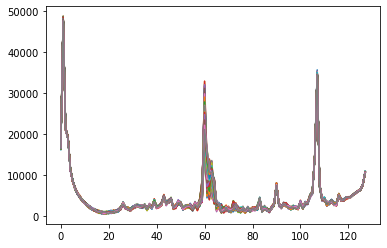

In [18]:
# Plot the range plot for each chirp
plt.plot(range_plot.T)
plt.show()

# Feel free to add any additional plots for futher analysis


In [19]:
#################### TODO ####################
"""
    Task: Analyze the radar data (range-doppler)
    Output: range_doppler [doppler_bins, range_bins]
    
    Details: Figure out why this data is special by producing a range-doppler to work with. 
                (Hint: Look more closely at the peak at range bin ~60)
    
             Note that this frame actually has 3 different dimensions (axes) to it.
             Axis 0 - Chirps
             Axis 1 - Virtual Antennas ***ignore the deep meaning of this for now, just treat it as 
                                          8 copies of [128, 128] frames and work around it then accumulate them together***
             Axis 2 - ADC Samples
"""
range_doppler = None

# Range FFT


# Doppler FFT and FFT shift


# Take magnitude and then accumulate (along the virtual antennas)


##############################################

In [20]:
""" REMOVE """
range_fft = np.fft.fft(frame, axis=2)
range_doppler = np.fft.fft(range_fft, axis=0)
range_doppler = np.fft.fftshift(range_doppler, axes=0)
range_doppler = np.log(np.abs(range_doppler)).sum(1)

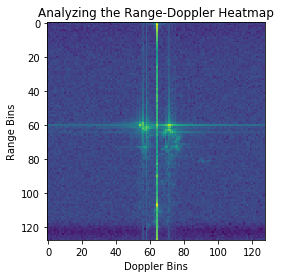

In [21]:
# Plot range-doppler plot as an image
plt.imshow(range_doppler.T)
plt.xlabel('Doppler Bins')
plt.ylabel('Range Bins')
plt.title('Analyzing the Range-Doppler Heatmap')
plt.show()

# Feel free to add any additional plots for futher analysis


## The Range-Doppler Plot



If you correctly analyzed the range-doppler plot, you should have seen that there are multiple objects at the same range. The only reason we are able to distinguish them is because they are moving in opposite directions from one another. Using this information in the movie example, we would could certainly have a lot more information on friend or foe and how quickly we need a decision.

# Extras

***

## Benefits from mmWave Radars

That last exercise may have seemed very straightforward, but there are already a lot of things within your reach. For example, I want to bring up Google Soli, a project that works with radars for gesture recognition ( https://atap.google.com/soli/ ). They use mmWave radars for their high sensitivity to movement and velocity. These properties enable small gestures using a hand or the fingers to be registered as some pattern in the data. Cameras would have a very hard time reading the minute changes from frame to frame, but mmWave radar doesn't have a problem since they are fundamentally different. After training on what specific gestures look like, Soli can classify the gestures as "change volume", "swipe", and many more. They go over some of the many benefits to doing this on their website and in their demo videos.

## Recap

This module has gone over how the radar takes advantage of the **doppler effect** to encode **velocity**. Small changes in the phase of ADC samples over multiple chirps can be used to track micro-movements and can then be converted into velocity. Applying this knowledge, we can perform a **doppler FFT** just like the range FFT to get a **range-doppler heatmap**. This heatmap is simple, but can be very powerful at determining a number of things. We showed one use of this by looking at a dopper-range plot with two objects at the same range, but opposite velocities. Range alone would not be able to help since the **two objects would have an additive affect in the range plot**, but the doppler fft gives us a **whole new dimension** to work with.

## Looking Forward

So far, we have been making a simplifying assumption about the radar we are using. That is because we have assumed that the radar we are using is a simple single receiver (RX) and single transmitter (TX). We can do a lot better. We now have access to radars using **MIMO TX/RX** setups. Just as we've learned that the ADC samples and chirps give us valuable measurements, MIMO gives us a new piece of information, **angle of arrival**.

***

#### Contributors
- Dash Kosaka

#### Questions, Issues, etc.?
Contact by...
- email - presenseradar@gmail.com
- github - https://github.com/presenseradar/openradar